# Prepare Optimized Model for Deployment

## IMPORTANT:  You Must STOP All Kernels and Terminal Sessions
The GPU may be wedged at this point.  We stop all kernels and terminal sessions to release the GPU resources.

# Freeze Fully Optimized Graph

In [101]:
from tensorflow.python.tools import freeze_graph

model_parent_path = './models/workshop/linear/cpu'

model_graph_path = '%s/unoptimized_cpu.pb' % model_parent_path
frozen_model_graph_path = '%s/frozen_model_graph_cpu.pb' % model_parent_path
model_checkpoint_path = '%s/model.ckpt' % model_parent_path

freeze_graph.freeze_graph(input_graph=model_graph_path, 
                          input_saver="",
                          input_binary=True, 
                          input_checkpoint=model_checkpoint_path,
                          output_node_names="add",
                          restore_op_name="save/restore_all", 
                          filename_tensor_name="save/Const:0",
                          output_graph=frozen_model_graph_path, 
                          clear_devices=True, 
                          initializer_nodes="")
print(frozen_model_graph_path)

INFO:tensorflow:Restoring parameters from ./models/workshop/linear/cpu/model.ckpt
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.
./models/workshop/linear/cpu/frozen_model_graph_cpu.pb


### File Size

In [102]:
%%bash

ls -l ./models/workshop/linear/cpu/

total 52
drwxr-xr-x 4 root root  4096 Sep  7 19:18 %s
-rw-r--r-- 1 root root    77 Sep  7 19:18 checkpoint
-rw-r--r-- 1 root root   392 Sep  7 19:23 frozen_model_graph_cpu.pb
-rw-r--r-- 1 root root     8 Sep  7 19:18 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 Sep  7 19:18 model.ckpt.index
-rw-r--r-- 1 root root 17774 Sep  7 19:18 model.ckpt.meta
-rw-r--r-- 1 root root 12064 Sep  7 19:18 unoptimized_cpu.pb


In [103]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))
        

In [104]:

input_graph='./models/workshop/linear/cpu/frozen_model_graph_cpu.pb'
output_dot='./frozen_model_graph_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file './frozen_model_graph_cpu.dot' for graph './models/workshop/linear/cpu/frozen_model_graph_cpu.pb'.


In [105]:
%%bash

dot -T png ./frozen_model_graph_cpu.dot \
    -o ./frozen_model_graph_cpu.png > /tmp/a.out

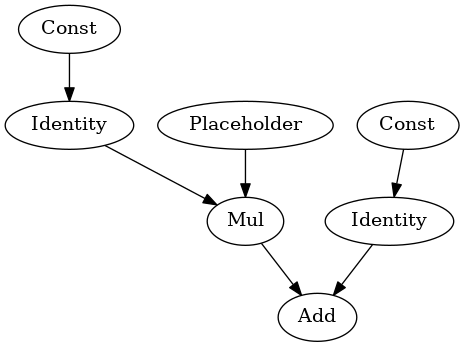

In [106]:
from IPython.display import Image

Image('./frozen_model_graph_cpu.png')

# Save Model for Deployment and Inference

## Reset Default Graph

In [107]:
import tensorflow as tf

tf.reset_default_graph()

## Create New Session

In [108]:
sess = tf.Session()

## Load Frozen Graph

In [109]:
from tensorflow.python.tools import inspect_checkpoint

inspect_checkpoint.print_tensors_in_checkpoint_file(file_name="./models/workshop/linear/cpu/model.ckpt",
                                                    tensor_name="",
                                                    all_tensors=True,
                                                    all_tensor_names=True)

tensor_name:  bias
0.2559045
tensor_name:  weights
0.18239756


In [110]:
saver = tf.train.import_meta_graph('./models/workshop/linear/cpu/model.ckpt.meta')
saver.restore(sess, './models/workshop/linear/cpu/model.ckpt')

model_parent_path = './models/workshop/linear/cpu'
frozen_model_graph_path = '%s/frozen_model_graph_cpu.pb' % model_parent_path
print(frozen_model_graph_path)

with tf.gfile.GFile(frozen_model_graph_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(
    graph_def, 
    input_map=None, 
    return_elements=None, 
    name="", 
    op_dict=None, 
    producer_op_list=None
)

print("weights = ", sess.run("weights:0"))
print("bias = ", sess.run("bias:0"))

INFO:tensorflow:Restoring parameters from ./models/workshop/linear/cpu/model.ckpt
./models/workshop/linear/cpu/frozen_model_graph_cpu.pb
weights =  0.18239756
bias =  0.2559045


## Create `SignatureDef` Asset for TensorFlow Serving


In [111]:
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils

graph = tf.get_default_graph()

x_observed = graph.get_tensor_by_name('x_observed:0')
y_pred = graph.get_tensor_by_name('add:0')

inputs_map = {'inputs': x_observed}
outputs_map = {'outputs': y_pred}

predict_signature = signature_def_utils.predict_signature_def(
                inputs = inputs_map, 
                outputs = outputs_map)
print(predict_signature)

inputs {
  key: "inputs"
  value {
    name: "x_observed:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
outputs {
  key: "outputs"
  value {
    name: "add:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
method_name: "tensorflow/serving/predict"



## Save Model with Assets


In [119]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants

from shutil import rmtree


saved_model_path = './models/workshop/saved_model/linear/cpu/0'
print(saved_model_path)

rmtree(saved_model_path)

builder = saved_model_builder.SavedModelBuilder(saved_model_path)
builder.add_meta_graph_and_variables(sess, 
                                     [tag_constants.SERVING],
                                     signature_def_map={'predict':predict_signature,                                     
signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:predict_signature}, 
                                     clear_devices=True,
)

builder.save(as_text=False)

./models/workshop/saved_model/linear/cpu/0
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/workshop/saved_model/linear/cpu/0/saved_model.pb


b'./models/workshop/saved_model/linear/cpu/0/saved_model.pb'

In [120]:
import os
print(saved_model_path)
os.listdir(saved_model_path)
os.listdir('%s/variables' % saved_model_path)

./models/workshop/saved_model/linear/cpu/0


['variables.index', 'variables.data-00000-of-00001']

In [121]:
%%bash
echo "./models/workshop/saved_model/linear/cpu/0"
echo ""
ls -al ./models/workshop/saved_model/linear/cpu/0

./models/workshop/saved_model/linear/cpu/0

total 36
drwxr-xr-x 3 root root  4096 Sep  7 19:25 .
drwxr-xr-x 3 root root  4096 Sep  7 19:25 ..
-rw-r--r-- 1 root root 22617 Sep  7 19:25 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep  7 19:25 variables


## Inspect with [Saved Model CLI](https://www.tensorflow.org/programmers_guide/saved_model_cli)
Note:  This takes a minute or two for some reason.  Please be patient.

In [122]:
import subprocess

output = subprocess.run(["saved_model_cli", "show", \
                "--dir", saved_model_path, "--all"], \
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE)

print(output.stdout.decode('utf-8'))


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: x_observed:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: add:0
  Method name is: tensorflow/serving/predict

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: x_observed:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: add:0
  Method name is: tensorflow/serving/predict



## Predict with Python (SLOW)

In [123]:
from tensorflow.contrib import predictor
import numpy as np

input_shape = 1
input_data = np.random.random_sample(input_shape)

predict_fn = predictor.from_saved_model(saved_model_path)

INFO:tensorflow:Restoring parameters from ./models/workshop/saved_model/linear/cpu/0/variables/variables


In [124]:
%%time
predictions = predict_fn({'inputs': input_data})

CPU times: user 5.08 ms, sys: 4.29 ms, total: 9.38 ms
Wall time: 7.34 ms


In [125]:
print('Prediction: %s' % predictions["outputs"])

Prediction: [0.36239418]


## (Optional) Saved Model -- Simple Save
Note:  This takes a minute or two for some reason.  Please be patient.

In [127]:
import tensorflow.saved_model as saved_model

from shutil import rmtree

simple_saved_model_path = './models/workshop/simple_saved_model/linear/cpu/0'
print(simple_saved_model_path)

rmtree(simple_saved_model_path)

saved_model.simple_save(sess,
            simple_saved_model_path,
            inputs={'inputs': x_observed},
            outputs={"outputs": y_pred})

./models/workshop/simple_saved_model/linear/cpu/0
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./models/workshop/simple_saved_model/linear/cpu/0/saved_model.pb


In [129]:
sess.close()

In [130]:
import subprocess

output = subprocess.run(["saved_model_cli", "show", \
                "--dir", simple_saved_model_path, "--all"], \
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE)

print(output.stdout.decode('utf-8'))


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: x_observed:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: add:0
  Method name is: tensorflow/serving/predict



## (Optional) Optimize with TensorFlow Lite

![PipelineAI + TensorFlow Lite](https://pipeline.ai/assets/img/toco-optimizer.png)

In [131]:
import tensorflow as tf
import os


from shutil import rmtree

tflite_model_path = './models/workshop/tflite/linear/cpu/0'
print(tflite_model_path)

rmtree(tflite_model_path)

os.makedirs(tflite_model_path, exist_ok=True)

converter = tf.contrib.lite.TocoConverter.from_saved_model(simple_saved_model_path)

tflite_model = converter.convert()

open('%s/tflite_optimized_model.tflite' % tflite_model_path, "wb").write(tflite_model)

./models/workshop/tflite/linear/cpu/0
INFO:tensorflow:Restoring parameters from ./models/workshop/simple_saved_model/linear/cpu/0/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: inputs
INFO:tensorflow: tensor name: x_observed:0, shape: (-1), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: outputs
INFO:tensorflow: tensor name: add:0, shape: (-1), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from ./models/workshop/simple_saved_model/linear/cpu/0/variables/variables
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.


688

In [132]:
%%bash -s "$tflite_model_path"
echo "ls -al $1"
echo ""
ls -al $1

ls -al ./models/workshop/tflite/linear/cpu/0

total 12
drwxr-xr-x 2 root root 4096 Sep  7 19:26 .
drwxr-xr-x 3 root root 4096 Sep  7 19:26 ..
-rw-r--r-- 1 root root  688 Sep  7 19:26 tflite_optimized_model.tflite


In [133]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path='%s/tflite_optimized_model.tflite' % tflite_model_path)
interpreter.allocate_tensors()

In [134]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
print('Input Tensor Details: %s' % input_details)

output_details = interpreter.get_output_details()
print('Output Tensor Details: %s' % output_details)

Input Tensor Details: [{'name': 'x_observed', 'index': 4, 'shape': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
Output Tensor Details: [{'name': 'add', 'index': 0, 'shape': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [135]:
# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('Input: %s' % input_data)
interpreter.set_tensor(input_details[0]['index'], input_data)

Input: [0.18819128]


In [136]:
%%time
interpreter.invoke()

CPU times: user 39 µs, sys: 7 µs, total: 46 µs
Wall time: 53.6 µs


In [137]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Prediction: %s' % output_data)

Prediction: [0.29023013]
